# MoSDeF + HOOMD + Freud simulations of LJ particles at multiple thermodynamic states

We will be attempting to reproduce some RDFs produced by Moore et al. (2014). 
In this publication, LJ particles were simulated at a variety of thermodynamic statepoints.

![moore2014.png](./moore2014.png)

Moore, T. C.; Iacovella, C. R.; McCabe, C. Derivation of Coarse-Grained Potentials via Multistate Iterative Boltzmann Inversion. J. Chem. Phys. 2014, 140 (22).

In [1]:
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
from mbuild.formats.gsdwriter import write_gsd
import foyer
import unyt as u
import hoomd
%matplotlib inline
import matplotlib.pyplot as plt
import freud
import gsd

We will outline some basic constants to facilitate conversions to and from unitless to physical dimensions.
The foyer XML within this repo contains the same force field information.

In [2]:
# Basic constants and LJ Argon properties
sig = 0.34 * u.nm
eps = 1 * u.kilojoule
mass = 39.948 * u.amu
kb_per_mol = u.boltzmann_constant * 6.022e23
n = 2000

In [7]:
!head -n15 ff.xml

<?xml version="1.0" encoding="UTF-8"?>
<ForceField >
  <!--XML units: kJ/mol for energies, nm for lengths, and radians for angles.-->
  <AtomTypes>
    <Type name="Ar" class="Ar" element="Ar" mass="39.948" def="[Ar]" desc="LJ Argon"/>
  </AtomTypes>
  <HarmonicBondForce>
  </HarmonicBondForce>
  <HarmonicAngleForce/>
  <RBTorsionForce>
  </RBTorsionForce>
  <NonbondedForce coulomb14scale="0.0" lj14scale="0.0">
    <Atom type="Ar" charge="0" sigma="0.34" epsilon="1.00"/>
  </NonbondedForce>
</ForceField>


In [3]:
# Define various thermodynamic state points, in reduced units
statepoints = {'a': {'T_r':0.5, 'rho_r':0.85},
                  'b': {'T_r':1.5, 'rho_r':0.67},
                  'c': {'T_r':2.0, 'rho_r':0.18}}

In [4]:
# Iterate through each thermodynamic statepoint, building, parametrizing, and simulating the system
for i, statepoint in statepoints.items():
    # Create LJ particle
    lj_compound = mb.Compound(name='Ar')
    
    # Create mbuild Box based on reduced density
    volume = n * sig**3 / statepoint['rho_r'] 
    cubic_box_length = volume **(1/3)
    box = mb.Box([cubic_box_length, cubic_box_length, cubic_box_length])
    
    # Use mbuild to pack box with LJ particles
    # Use freud to wrap coordinates within box
    freud_box = freud.box.Box.from_box(box.lengths)
    filled_box = mb.fill_box(lj_compound, n_compounds=n, box=box)
    filled_box.xyz = freud_box.wrap(filled_box.xyz)
    
    # Apply foyer force field
    ff = foyer.Forcefield('ff.xml')
    structure = ff.apply(filled_box)
    
    # Dump initial coordinates
    write_gsd(structure, '{}_init.gsd'.format(i), ref_distance=10, ref_energy=1/4.184)

    # Initialize hoomd simulation with relevant force field parameters
    hoomd.context.initialize("")
    snapshot, ref_vals = create_hoomd_simulation(structure, ref_distance=10, ref_energy=1/4.184)
    
    # Define hoomd group for dumping and integrating
    all_group = hoomd.group.all()

    # Dump coordinates to GSD file
    gsd_dump = hoomd.dump.gsd('{}.gsd'.format(i), 100, all_group, overwrite=True)
    
    # Define integration timestep
    hoomd.md.integrate.mode_standard(0.005)
    
    # Specify integrator with velocity randomization
    integrator = hoomd.md.integrate.nvt(all_group, statepoint['T_r'], 1.0)
    integrator.randomize_velocities(42)
    
    hoomd.run(10000)


HOOMD-blue v2.8.0-1-ga4de8f0a9 DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 
Compiled: 10/31/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


/Users/ayang41/anaconda3/envs/py36/lib/python3.6/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)


notice(2): Group "all" created containing 2000 particles


*Warning*: nlist: No bonds defined while trying to add topology derived 1-3 exclusions


notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
Processing LJ and QQ
notice(2): Group "charged" created containing 0 particles
No charged groups found, ignoring electrostatics
HOOMD SimulationContext updated from ParmEd Structure
** starting run **
Time 00:00:10 | Step 1551 / 10000 | TPS 155.085 | ETA 00:00:54
Time 00:00:20 | Step 2619 / 10000 | TPS 106.732 | ETA 00:01:09
Time 00:00:30 | Step 3755 / 10000 | TPS 113.289 | ETA 00:00:55
Time 00:00:40 | Step 4345 / 10000 | TPS 58.9882 | ETA 00:01:35
Time 00:00:50 | Step 5001 / 10000 | TPS 65.4659 | ETA 00:01:16
Time 00:01:00 | Step 6204 / 10000 | TPS 120.21 | ETA 00:00:31
Time 00:01:10 | Step 7506 / 10000 | TPS 130.121 | ETA 00:00:19
Time 00:01:20 | Step 9048 / 10000 | TPS 154.138 | ETA 00:00:06
Time 00:01:26 | Step 10000 / 10000 | TPS 162.066 | ETA 00:00:00
Average T

/Users/ayang41/anaconda3/envs/py36/lib/python3.6/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)
*Warning*: nlist: No bonds defined while trying to add topology derived 1-3 exclusions


notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
Processing LJ and QQ
notice(2): Group "charged" created containing 0 particles
No charged groups found, ignoring electrostatics
HOOMD SimulationContext updated from ParmEd Structure
** starting run **
Time 00:00:10 | Step 1700 / 10000 | TPS 169.772 | ETA 00:00:48
Time 00:00:20 | Step 3179 / 10000 | TPS 147.885 | ETA 00:00:46
Time 00:00:30 | Step 4801 / 10000 | TPS 161.901 | ETA 00:00:32
Time 00:00:40 | Step 6486 / 10000 | TPS 168.273 | ETA 00:00:20
Time 00:00:50 | Step 8220 / 10000 | TPS 173.329 | ETA 00:00:10
Time 00:01:00 | Step 9935 / 10000 | TPS 171.499 | ETA 00:00:00
Time 00:01:00 | Step 10000 / 10000 | TPS 191.456 | ETA 00:00:00
Average TPS: 165.587
---------
-- Neighborlist stats:
119 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n

/Users/ayang41/anaconda3/envs/py36/lib/python3.6/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)
*Warning*: nlist: No bonds defined while trying to add topology derived 1-3 exclusions


notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
Processing LJ and QQ
notice(2): Group "charged" created containing 0 particles
No charged groups found, ignoring electrostatics
HOOMD SimulationContext updated from ParmEd Structure
** starting run **
Time 00:00:10 | Step 5458 / 10000 | TPS 545.789 | ETA 00:00:08
Time 00:00:18 | Step 10000 / 10000 | TPS 543.464 | ETA 00:00:00
Average TPS: 544.706
---------
-- Neighborlist stats:
173 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 96 / n_neigh_avg: 39.2555
shortest rebuild period: 8
-- Cell list stats:
Dimension: 4, 4, 4
n_min    : 20 / n_max: 40 / n_avg: 31.25
** run complete **


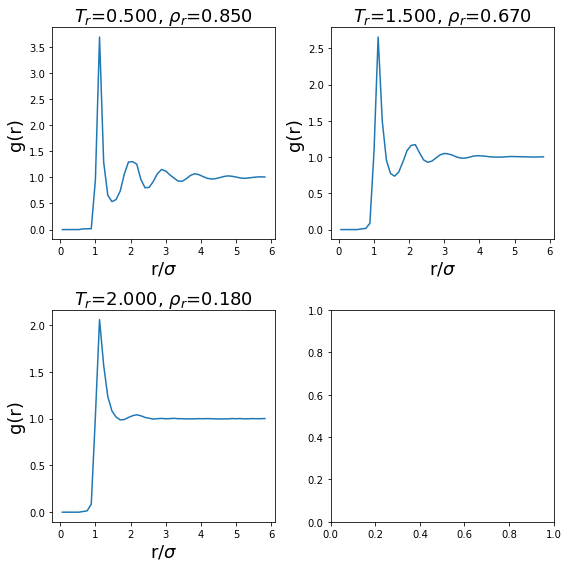

In [5]:
# Analyze the simulations by computing RDFs via freud
fig, ax = plt.subplots(2,2, figsize=(8,8))
for i, name in enumerate(statepoints):
    with gsd.hoomd.open('{}.gsd'.format(name), 'rb') as f:
        freud_rdf = freud.density.RDF(bins=50, r_max=2, r_min=0)
        for frame in f:
            freud_rdf.compute(system=frame, reset=False)
    row = i // 2
    col = i % 2
    
    density = statepoints[name]['rho_r']
    temperature = statepoints[name]['T_r']
    
    ax[row, col].set_ylabel("g(r)", size=18)
    ax[row, col].set_xlabel(r"r/$\sigma$", size=18)
    
    ax[row, col].set_title(r"$T_r$={:.3f}, $\rho_r$={:.3f}".format(temperature, density), size=18)
    ax[row, col].plot(freud_rdf.bin_centers/sig, freud_rdf.rdf)
    fig.tight_layout()


![moore2014.png](./moore2014.png)

Moore, T. C.; Iacovella, C. R.; McCabe, C. Derivation of Coarse-Grained Potentials via Multistate Iterative Boltzmann Inversion. J. Chem. Phys. 2014, 140 (22).